# NASA SERVIR Ucayali

<div class="alert alert-block alert-warning"> This draft manuscript is distributed solely for purposes of scientific peer review. Its content is deliberative and predecisional, so it must not be disclosed or released by reviewers. Because the manuscript has not yet been approved for publication by the U.S. Geological Survey (USGS), it does not represent any official USGS finding or policy. </div>

In [1]:
import os 
import requests as rq
import pandas as pd
import geopandas as gpd
import folium
import geojson
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio as rio
import rioxarray
from rioxarray import merge
from rasterio.session import AWSSession
from rasterio.plot import show as rio_show
from rasterio.windows import from_bounds
from shapely.geometry import Polygon
import hvplot.xarray
import hvplot.pandas
import numpy as np
import boto3
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'requests'

In [ ]:
aoi_gdf =  gpd.read_file(os.path.join('ucayali_boundary.geojson')) #aoi geopandas dataframe
aoi_geojson = aoi_gdf.__geo_interface__

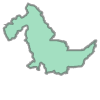

In [ ]:
aoi_gdf.geometry[0]

## Setup STAC Funtions

In [ ]:
def fetch_stac_server(query):
    '''
    Queries the stac-server (STAC) backend.
    query is a python dictionary to pass as json to the request.
    '''
    
    search_url = f"https://landsatlook.usgs.gov/stac-server/search"
    query_return = rq.post(search_url, json=query).json()
    error = query_return.get("message", "")
    if error:
        raise Exception(f"STAC-Server failed and returned: {error}")
        
    if 'code' in query_return:
        print(query_return)   
    else:
        print(f"{len(query_return['features'])} STAC items found")
        return query_return['features']
 

In [ ]:
def send_STAC_query(limit=20, collections=None, intersects=None, datetime=None, bbox=None):
    '''
    This function helps to create a simple parameter dcitionary for querying 
    the Landsat Collection 2 Level 2 Surface Reflectance feature in the STAC Server.
    It prints the parameter dictionary and returns the query results.
    '''
    params = {}
    if limit is not None:
        params['limit'] = limit
    
    if collections is not None:
        params['collections'] = collections
        
    if intersects is not None:
        params['intersects'] = intersects
        
    if datetime is not None:
        params['datetime'] = datetime
        
    if bbox is not None:
        params['bbox'] = bbox
        
    # print(params) 
    
    return fetch_stac_server(params)

In [ ]:
# def retrieve_scenes(coords):
#     query_items = []
#     # Define the step size for slicing
#     step = 1000

#     # Loop through the coord list with a step size of 1000
#     for i in range(0, len(coords), step):
#         # Slice the coord list to get 1000 points
#         # print(f"{i}:{i+step}")
#         points = coords[i:i+step]

#         # Update the point_intersects dictionary
#         point_intersects = {'type': 'Multipoint', 'coordinates': points}
#         query_items.extend(send_STAC_query(limit=2000, collections='landsat-c2l2-sr', intersects=point_intersects, datetime=date_time))

#         # Use a set to store unique IDs seen so far
#         seen_ids = set()
#         unique_items = []

#         for item in query_items:
#             # Check if the 'id' key exists and its value is not already seen
#             if 'id' in item and item['id'] not in seen_ids:
#                 seen_ids.add(item['id'])  # Add the ID to the seen set
#                 unique_items.append(item)  # Add the unique item to the result list
#     return unique_items

# query_returns = retrieve_scenes(coords = [coord for coord in aoi_geojson['features'][0]['geometry']['coordinates'][0]])

## Separate GEOJSON into Windows

In [ ]:
def create_windows(aoi_gdf):
    # Define the window size (in degrees)
    window_size = 0.5  # Adjust this value as needed

    # Extract total bounds from the GeoDataFrame
    xmin, ymin, xmax, ymax = aoi_gdf.total_bounds

    # Calculate the number of sub-windows along x and y axes
    num_x_windows = int(np.ceil((xmax - xmin) / window_size))
    num_y_windows = int(np.ceil((ymax - ymin) / window_size))

    # Initialize a list to store the bounds of each sub-window
    sub_window_bounds = []

    # Iterate over each sub-window
    for i in range(num_x_windows):
        for j in range(num_y_windows):
            # Calculate the bounds of the current sub-window
            sub_xmin = xmin + i * window_size
            sub_ymin = ymin + j * window_size
            sub_xmax = min(sub_xmin + window_size, xmax)
            sub_ymax = min(sub_ymin + window_size, ymax)

            # Append the bounds of the current sub-window to the list
            sub_window_bounds.append((sub_xmin, sub_ymin, sub_xmax, sub_ymax))

    # Print the bounds of each sub-window
    # for idx, bounds in enumerate(sub_window_bounds):
    #     print(f"Sub-window {idx+1}: {bounds}")

    # Define a list to store sub-windows that intersect the AOI
    intersecting_sub_windows = []

    # Iterate over each sub-window bounds
    for bounds in sub_window_bounds:
        sub_xmin, sub_ymin, sub_xmax, sub_ymax = bounds

        # Create a GeoDataFrame for the sub-window bounds
        sub_window_gdf = gpd.GeoDataFrame(geometry=[Polygon([(sub_xmin, sub_ymin), (sub_xmin, sub_ymax), (sub_xmax, sub_ymax), (sub_xmax, sub_ymin)])])

        # Check if the sub-window intersects with the AOI
        if sub_window_gdf.intersects(aoi_gdf.unary_union).any():
            intersecting_sub_windows.append(bounds)

    # Display sub-windows that intersect the AOI
    # print("Sub-windows that intersect the AOI:")
    # for bounds in intersecting_sub_windows:
    #     print(bounds)
    print(f'{len(intersecting_sub_windows)} total windows')
    return intersecting_sub_windows

## Get Landsat Scenes

In [ ]:
windows = create_windows(aoi_gdf)
test_window = 0
window = windows[test_window]

57 total windows


In [ ]:
# use the specified datetime format to create string variable of desired time range
year = 2001
date_time = f'{year}-09-01T00:00:00Z/{year+1}-03-15T23:59:59Z'
date_time

'2001-09-01T00:00:00Z/2002-03-15T23:59:59Z'

In [ ]:
tuple(window)

(-75.94788601799996,
 -9.448341979999952,
 -75.44788601799996,
 -8.948341979999952)

In [ ]:
query_returns = send_STAC_query(limit=1000, collections='landsat-c2l2-sr', bbox=tuple(window), datetime=date_time)

42 STAC items found


In [ ]:
# [print(query_item['properties']['proj:epsg']) for query_item in query_returns]

## Plot AOI and Query Results using Folium

In [ ]:
map = folium.Map(location=[aoi_gdf.centroid.y[0], aoi_gdf.centroid.x[0]], zoom_start=7, tiles="openstreetmap",\
              width='90%', height='90%') #set base map details centered at the center of the polygon [latitude longitude]
folium.GeoJson(data=aoi_gdf["geometry"], name="LineString", style_function=lambda feature: {'color': 'red', 'fill': False}).add_to(map) # add polygon


    
# Define an HTML color code for imported scenes (e.g., blue color)
scene_edge_color = "#4C4C4C"

# Add extent of scenes from bbox query
for feature in  query_returns:   
    folium.GeoJson(
        feature,
        name="Additional Polygon",
        style_function=lambda feature: {
            "fillColor": scene_edge_color,
            "color": scene_edge_color,
            "weight": 1.5,
            "dashArray": "5, 5",
            "fillOpacity": 0,
        },
    ).add_to(map)


# Iterate over each sub-window bounds and add a rectangle to the map
for idx, bounds in enumerate(windows):
    sub_xmin, sub_ymin, sub_xmax, sub_ymax = bounds
    rectangle = folium.Rectangle(
        bounds=((sub_ymin, sub_xmin), (sub_ymax, sub_xmax)),
        color='blue', fill=False, fill_color='white',
        tooltip=f'Window {idx}'  # Add tooltip with index
    )
    map.add_child(rectangle)
    
map

# Setup Processing Functions

In [ ]:
def get_SR_band_links(query_item):
    band_names = ['blue', 'green','red', 'nir08', 'swir16', 'swir22']

    band_links = []
    
    for b in band_names: #sort through a string to find relevant band names
            band_links.append(query_item['assets'][b]['alternate']['s3']['href'])

    return band_links

In [ ]:
def get_QA_band_link(query_item):
    return query_item['assets']['qa_pixel']['alternate']['s3']['href']

In [ ]:
def reproject_window(window, aoi_gdf, dst_crs):
    # dst_crs = 'EPSG:32619'  # UTM Zone 19N
    # Reproject the first intersecting sub-window to the CRS of the TIFF file
    return  rio.warp.transform_bounds(
        src_crs=aoi_gdf.crs,
        dst_crs=dst_crs,
        left=window[0],
        bottom=window[1],
        right=window[2],
        top=window[3]
    )


def retrieve_cog(geotiff_path, window, aoi_gdf):
    """
    Retrieve a Cloud-Optimized GeoTIFF (COG) within a specified bounding box.

    Parameters:
        - geotiff_path (str): Path to the COG GeoTIFF file.
        - aoi_gdf (geopandas.GeoDataFrame): GeoDataFrame representing the area of interest.

    Returns:
        - cog (numpy.ndarray): Numpy array containing the data within the specified bounding box.
    """
    aws_session = AWSSession(boto3.Session(), requester_pays=True)
    with rio.Env(aws_session):
        with rio.open(geotiff_path) as tif:
            # Reproject the GeoTIFF to EPSG:32619
            # dst_crs = 'EPSG:32619'  # UTM Zone 19N
            dst_crs = tif.crs
            window = reproject_window(window, aoi_gdf, dst_crs)
            
            if tif.crs == dst_crs:
                # print(window)
                cog = tif.read(1, window=from_bounds(
                    window[0],
                    window[1],
                    window[2],
                    window[3],
                    tif.transform), boundless=True, fill_value=0)
                cog = np.array(cog)
            else:  
                cog = reproject_and_clip_tif(geotiff_path, window, dst_crs='EPSG:32619')

    return cog


def retrieve_spectral_data(query_returns, window, aoi_gdf):
    cog = (retrieve_cog(get_SR_band_links(query_returns[0])[0], window, aoi_gdf))
    row, col = cog.shape
    spectral_arr = np.zeros(shape=(6, len(query_returns), row, col), dtype=int)
    qa_arr = np.zeros(shape=(len(query_returns), row, col), dtype=int)

    for idx1, query_item in enumerate(query_returns):
        print(f" Pulling: {idx1} {query_item['id']}")
        band_links = get_SR_band_links(query_item)

        qa_link = get_QA_band_link(query_item)

        for idx2, b in enumerate(band_links):
            spectral_arr[idx2, idx1] = retrieve_cog(b,  window, aoi_gdf)

        qa_arr[idx1] = retrieve_cog(qa_link,  window, aoi_gdf)
        
    return (row, col), spectral_arr, qa_arr

<!-- # import rasterio
# from rasterio.warp import reproject

# # Open the input raster dataset
# with rasterio.open('input.tif') as src:
#     # Get the source raster's coordinate reference system (CRS)
#     src_crs = src.crs

#     # Define the destination CRS
#     dst_crs = 'EPSG:32619'

#     # Reproject the source raster to the destination CRS
#     with rasterio.open('output.tif', 'w', **src.meta) as dst:
#         reproject(
#             source=src,
#             destination=dst,
#             src_crs=src_crs,
#             dst_crs=dst_crs,
#             resampling=rasterio.enums.Resampling.nearest
#         )

# # Clip the reprojected raster to the window
# with rasterio.open('output.tif') as src:
#     window = rasterio.windows.Window(0, 0, src.width, src.height)
#     clipped = src.read(window=window)

# # Save the clipped raster
# with rasterio.open('clipped.tif', 'w', **src.meta) as dst:
#     dst.write(clipped)  -->

In [ ]:
# def reproject_and_clip_tif(tif_path, wndw, dst_crs='EPSG:32619'):
#     """
#     Reprojects a TIF to the specified destination CRS, clips it within a window,
#     and finds the intersection indices.

#     Args:
#       tif_path (str): Path to the TIF file.
#       window (tuple): Bounding box coordinates in the destination CRS (dst_crs).
#       dst_crs (str, optional): Destination coordinate reference system (default 'EPSG:32619').

#     Returns:
#       tuple: (clipped_data, reprojected_transform, intersection_indices) containing the
#               clipped data, its transform, and the intersection indices as a tuple (x_start, row_end, y_start, y_end).
#     """

#     aws_session = AWSSession(boto3.Session(), requester_pays=True)
#     with rio.Env(aws_session):
#         with rio.open(tif_path) as src:
#             # Get source CRS and data
#             src_crs = src.crs
#             src_data = src.read(1)  # Read the first band (modify for all bands if needed)

#             # Reproject data and transform to destination CRS
#             reprojected_data, reprojected_transform = rio.warp.reproject(
#                 src_data,
#                 src_transform=src.transform,
#                 src_crs=src_crs,
#                 dst_crs=dst_crs,
#                 dst_bounds=(wndw[0], wndw[1], wndw[2], wndw[3]),
#                 dst_nodata =0,
#                 resampling=rio.warp.Resampling.nearest,  # Choose appropriate resampling method
#                 src_nodata= 0
#             )

#             reprojected_data = reprojected_data[0]
#             # Create a window in the reprojected CRS
#             reprojected_window = rio.windows.from_bounds(*wndw, transform=reprojected_transform)
#             print(reprojected_window)

#             # Convert window bounds to row and column indices
#             y_start, x_start = np.int(np.ceil(reprojected_window.row_off)), np.int(np.ceil(reprojected_window.col_off))
#             y_end, x_end = np.int(np.ceil(reprojected_window.width + reprojected_window.row_off)), np.int(np.ceil(reprojected_window.height + reprojected_window.col_off))

#             print(x_start, y_start, x_end, y_end)
#             # Ensure that the indices are within the bounds of the reprojected data
#             x_start = max(0, min(x_start, reprojected_data.shape[0]))
#             x_end = max(0, min(x_end, reprojected_data.shape[0]))
#             y_start = max(0, min(y_start, reprojected_data.shape[1]))
#             y_end = max(0, min(y_end, reprojected_data.shape[1]))

#             # Return the reprojected data and transform
#     return reprojected_data[x_start:x_end, y_start:y_end]

In [ ]:
# what were you doing here: trying to figure out how to reproject the tif files to ESPSg ..19 before clippping, but the sizes are changing still ugh

In [ ]:
# for idx1, query_item in enumerate(filter_returns(query_returns)):
#     band_links = get_SR_band_links(query_item)
#     print(idx1)
#     for idx2, b in enumerate(band_links):
#         cog = retrieve_cog(b, window, aoi_gdf)
#         print(cog.shape)

In [ ]:
def filter_returns(query_returns):
    
    print('Filtering Query Returns')
    from collections import Counter

    # Extract EPSG values from query items
    epsg_values = [query_item['properties']['proj:epsg'] for query_item in query_returns]

    # Count occurrences of each EPSG value
    epsg_counts = Counter(epsg_values)

    # Find the most common EPSG value and its count
    most_common_epsg, most_common_count = epsg_counts.most_common(1)[0]

    # Filter query items to keep only those with the most common EPSG value
    filtered_query_returns = [query_item for query_item in query_returns if query_item['properties']['proj:epsg'] == most_common_epsg]

    # Print the most common EPSG value and the filtered query items
    print(" Most common EPSG value:", most_common_epsg)
    if len(filtered_query_returns) < len(query_returns):
        print(f" Removed {np.abs(len(filtered_query_returns)-len(query_returns))} items from list")
    print(f" Using - {len(filtered_query_returns)} - scenes")
    # for query_item in filtered_query_returns:
    #     print(query_item['properties']['proj:epsg'])
    return filtered_query_returns

In [ ]:
def qa_mask(qa_rod, mask_type):
    """
    Creates a boolean mask based on the specified filter type. Where True indicates presence

    Args:
        qa_arr (np.ndarray): The quality assessment array.
        mask_type (str): The type of mask to create. Valid options are:
            "fill", "dilated", "cirrus", "cloud", "shadow", "snow", "clear" and "water"

    Returns:
        np.ndarray: The boolean mask.

    Raises:
        ValueError: If an invalid mask type is provided.
    """

    masks = {
        "fill": 0,
        "dilated": 1,
        "cirrus": 2,
        "cloud": 3,
        "shadow": 4,
        "snow": 5,
        "clear": 6,
        "water": 7
    }
    
    mask_type = mask_type.lower()  # Convert mask type to lowercase
    
    if mask_type not in masks:
        raise ValueError(f"Invalid mask type: {mask_type}")

    bit = masks[mask_type]
    return (qa_rod & 1 << bit) > 0

In [ ]:
def qa_filter(spectral_rod, qa_rod):
    # index of observations without clouds
    clear_idxs = [idx for idx, val in enumerate(~(qa_mask(qa_rod, 'cloud'))) if val]

    # filling the bands array with zeros ensures that when the mask_idx is null values will still be passed through
    if len(clear_idxs) == 0:
        #make the band array the size of the spectral_rod if the mask array is empty
        filtered_rod = bands = [[0] * spectral_rod.shape[1] for _ in range(spectral_rod.shape[0])]
    else: 
        filtered_rod = spectral_rod[:, clear_idxs]

    # print('bands:', bands)
    return np.array(filtered_rod)

In [ ]:
def process_rod(spectral_rod, qa_rod):
    
    filtered_rod = qa_filter(spectral_rod, qa_rod)
    obs_idx = np.argmax(calculate_ndvi(filtered_rod))
    
    return filtered_rod[:,obs_idx]

In [ ]:
def calculate_ndvi(spectral_rod):
    obs_ndvi = np.zeros(spectral_rod.shape[1])
    for i in range(np.shape(spectral_rod)[1]):
        if spectral_rod[:,i][3] != 0 and spectral_rod[:,i][2] !=0:
            obs_ndvi[i] = (spectral_rod[:,i][3] - spectral_rod[:,i][2]) / (spectral_rod[:,i][3] + spectral_rod[:,i][2])
    return obs_ndvi

In [ ]:
def process_window(spectral_arr, qa_arr):
    num_bands, rows, cols = spectral_arr.shape[0], spectral_arr.shape[2], spectral_arr.shape[3]

    # create empty array of zeros
    out_comp = [[[0] * cols for _ in range(rows)] for _ in range(num_bands)]
    # out_n_clear_obs = np.array([[[0] * cols for _ in range(rows)]])
    
    processed_pixels = 0
    for row in range(spectral_arr.shape[2]):
        for col in range(spectral_arr.shape[3]):
            out_vals = process_rod(spectral_arr[:, :, row, col], qa_arr[:, row, col])
            
            # Increment the count of processed pixels
            processed_pixels += 1
            # Check if 25% of the pixels have been processed
            if processed_pixels % np.ceil((rows * cols)//10) == 0:
                # Calculate the percentage of completion
                print(f"  > {processed_pixels / (rows * cols) * 100:.0f}% of pixels processed...")
            
            #fill out array
            for b_idx, val in enumerate(out_vals):
                out_comp[b_idx][row][col] = val
                
    return np.array(out_comp)

# Run Composite Processing

In [ ]:
(height, width), spectral_arr, qa_arr  = retrieve_spectral_data(filter_returns(query_returns), window, aoi_gdf)

In [ ]:
out_arr = process_window(spectral_arr, qa_arr)

In [ ]:
out_arr.shape

### Save Raster

In [ ]:
def get_geometry(query_returns, window, aoi_gdf):
    # Path to the GeoTIFF file
    tif_path = get_SR_band_links(filter_returns(query_returns)[0])[0]
    aws_session = AWSSession(boto3.Session(), requester_pays=True)
    with rio.Env(aws_session):
        # Open the GeoTIFF file
        with rio.open(tif_path) as src:
            return src.crs.to_wkt(), src.window_transform(rio.windows.from_bounds(*reproject_window(window, aoi_gdf, src.crs), src.transform))

In [ ]:
crs, transform = get_geometry(query_returns, window, aoi_gdf)

In [ ]:
#%%====================== Set out file names ============================
out_comp_tif = f'comp_peru_{test_window:03d}_{year}.tif'
with rio.open(out_comp_tif, 'w', driver='COG', compress='lzw', nodata=None, width=width, height=height,
              count=6, dtype='uint16', crs=crs, transform=transform) as out_comp_dataset:
    out_comp_dataset.write(out_arr)

### Plot Results

In [ ]:
plt.figure(figsize=(12, 12))

# Select the desired bands in the appropriate order
bands = [out_arr[5, :, :], out_arr[3, :, :], out_arr[2, :, :]]  # Bands 5, 3, and 2

# Normalize each band to 0-1 range
bands = [(band_array / band_array.max()).astype(np.float32) for band_array in bands]

# Create the composite image
composite = np.stack(bands, axis=-1)

# Display the composite
plt.imshow(composite)
plt.show()

## Plot all Spectral Arrays

In [ ]:
for i in range(spectral_arr.shape[1]):
    sp_arr = spectral_arr[:,i]

    # Select the desired bands in the appropriate order
    bands_arr = [sp_arr[5, :, :], sp_arr[3, :, :], sp_arr[2, :, :]]  # Bands 5, 3, and 2


    # Initialize an empty list to store the RGB bands
    scaled_bands = []
    composite = []

    # Loop through each band data and transform
    for band_array in bands_arr:
        # Append the band data after scaling to 0-1 range
        scaled_bands.append((band_array / band_array.max()).astype(np.float32))

    # Create a natural color composite using the RGB bands
    composite = np.stack(scaled_bands, axis=-1)

    # Display the natural color composite
    plt.imshow(composite)
    plt.show()  



In [ ]:
# for q in query_returns:
#     print(q['properties']['proj:epsg'], q['properties']['proj:transform'], q['properties']['proj:shape'])